In [135]:
import pandas as pd
import tiktoken
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time
import json
import google.generativeai as genai
from constants import GEMINI_KEY

# ----------------------------
# 1. Load synthetic results
# ----------------------------
df = pd.read_csv("results/synthetic_dataset_gemini.csv")

print("Number of generated patients:", len(df))
print("\nFirst few rows:")
print(df.head())


Number of generated patients: 100

First few rows:
                                   discharge_summary primary_icd_code  \
0  **HOSPITAL DISCHARGE SUMMARY**\n\nPatient: Mx....            M1711   
1  **DISCHARGE SUMMARY**\n\n**Patient Name:** Mr....            M1711   
2  **Hospital Discharge Summary**\n\n**Patient Id...            M1710   
3  **Hospital Discharge Summary**\n\nPatient: Mr....            M1711   
4  Unit No: \_\_\_\n\nAdmission Date: [Date] Disc...            M1711   

   secondary_icd_codes  
0  W5981;S81819D;T656X  
1         A3951;I82C22  
2    M87061;1542;E7210  
3   G909;O3102;W2211XA  
4      S50361S;S12190A  


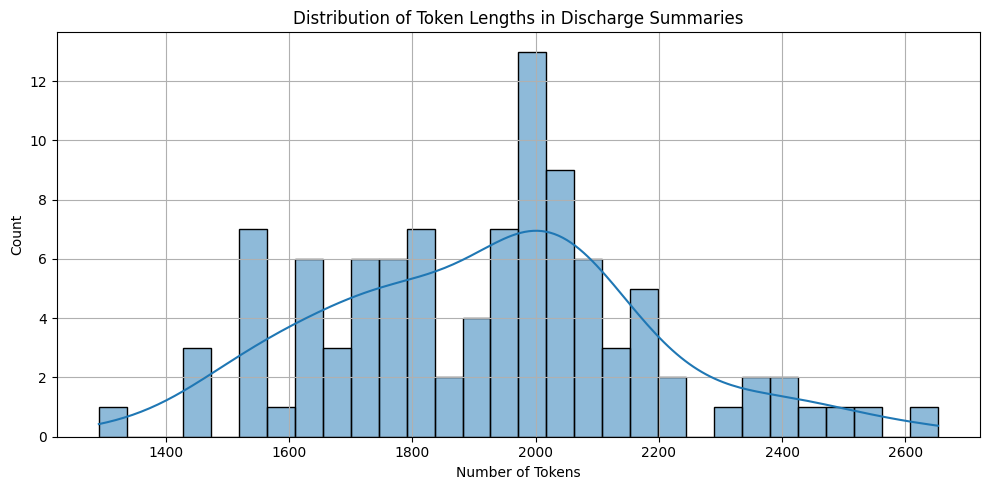

In [136]:
# ----------------------------
# 2. Token length distribution
# ----------------------------
encoding = tiktoken.encoding_for_model("gpt-4")
df["token_length"] = df["discharge_summary"].apply(lambda x: len(encoding.encode(str(x))))

plt.figure(figsize=(10, 5))
sns.histplot(df["token_length"], bins=30, kde=True)
plt.title("Distribution of Token Lengths in Discharge Summaries")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# 3. Check for duplicated texts
# ----------------------------
duplicates = df[df.duplicated("discharge_summary")]
print(f"\nNumber of exact duplicate discharge summaries: {len(duplicates)}")

KeyError: Index(['discharge_summary_cleaned'], dtype='object')

In [ ]:
# ----------------------------
# 4. Basic similarity check between summaries (cosine)
# ----------------------------
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df["discharge_summary_cleaned"].fillna(""))
sim_matrix = cosine_similarity(X)

# Avoid self-similarity (diagonal = 1.0)
import numpy as np
np.fill_diagonal(sim_matrix, 0)

most_similar_pairs = (sim_matrix > 0.9).sum() // 2  # count pairs > 90% similarity
print(f"\nNumber of very similar pairs (cosine similarity > 0.9): {most_similar_pairs}")


Number of very similar pairs (cosine similarity > 0.9): 0


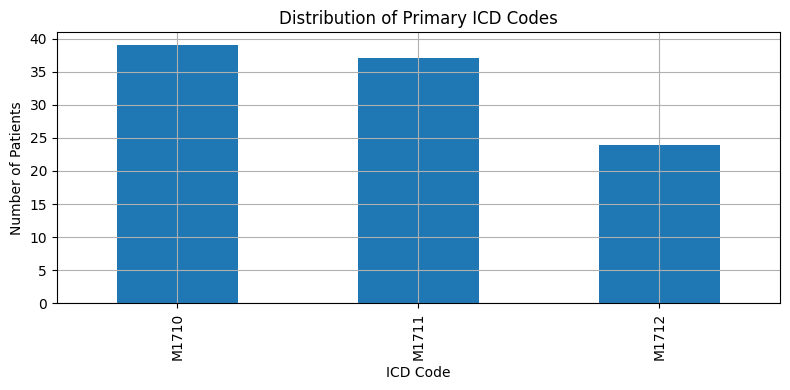


Most common secondary ICD codes:
W5981: 1 patients
S81819D: 1 patients
T656X,A3951: 1 patients
I82C22,M87061: 1 patients
1542: 1 patients
E7210,G909: 1 patients
O3102: 1 patients
W2211XA,S50361S: 1 patients
S12190A,I25700: 1 patients
Y01: 1 patients


In [ ]:

# ----------------------------
# 5. Primary ICD code distribution
# ----------------------------
plt.figure(figsize=(8, 4))
df["primary_icd_code"].value_counts().plot(kind="bar")
plt.title("Distribution of Primary ICD Codes")
plt.xlabel("ICD Code")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Secondary ICD codes stats
# ----------------------------
all_secondary = ",".join(df["secondary_icd_codes"].fillna("")).split(";")
secondary_counter = Counter(all_secondary)
most_common_secondary = secondary_counter.most_common(10)
print("\nMost common secondary ICD codes:")
for code, count in most_common_secondary:
    print(f"{code}: {count} patients")

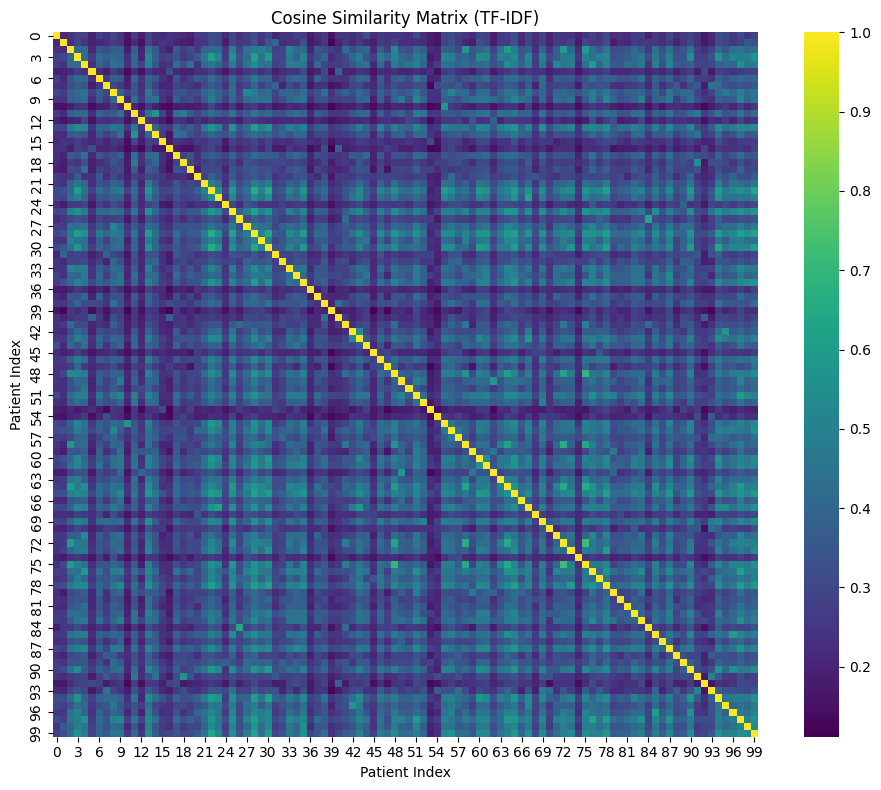

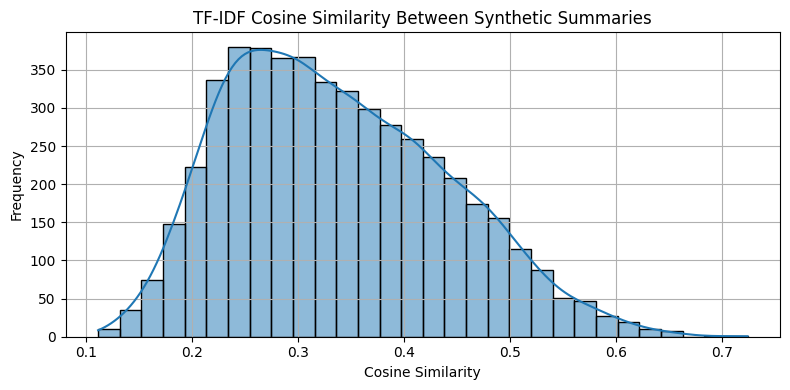

🔎 TF-IDF Cosine Similarity Stats:
Min: 0.1117
Max: 0.7242
Mean: 0.3375
> 0.9: 0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ----------------------------
# 1. Load summaries
# ----------------------------
df = pd.read_csv("results/synthetic_dataset_gemini.csv")
texts = df["discharge_summary"].fillna("").tolist()

# ----------------------------
# 2. Compute TF-IDF cosine similarity matrix
# ----------------------------
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(texts)
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# ----------------------------
# 3. Plot similarity matrix heatmap
# ----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, cmap="viridis", square=True, cbar=True)
plt.title("Cosine Similarity Matrix (TF-IDF)")
plt.xlabel("Patient Index")
plt.ylabel("Patient Index")
plt.tight_layout()
plt.show()

# ----------------------------
# 4. Flatten similarity scores for histogram
# ----------------------------
upper_tri = np.triu_indices_from(cosine_sim_matrix, k=1)
similarity_scores = cosine_sim_matrix[upper_tri]

plt.figure(figsize=(8, 4))
sns.histplot(similarity_scores, bins=30, kde=True)
plt.title("TF-IDF Cosine Similarity Between Synthetic Summaries")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Print summary statistics
# ----------------------------
print(f"🔎 TF-IDF Cosine Similarity Stats:")
print(f"Min: {similarity_scores.min():.4f}")
print(f"Max: {similarity_scores.max():.4f}")
print(f"Mean: {similarity_scores.mean():.4f}")
print(f"> 0.9: {(similarity_scores > 0.9).sum()}")